## Imports

### Modules and cores

In [1]:
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from abacusnbody.data.read_abacus import read_asdf
import h5py
import os

import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors

import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf

from scipy.spatial import KDTree, cKDTree
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from scipy.integrate import quad

from collections import Counter
from pycorr import TwoPointCorrelationFunction

import psutil
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import gc
import pickle

import importlib
import functions
importlib.reload(functions)
from functions import *

In [2]:
nthreads = psutil.cpu_count(logical=True)
ncores = psutil.cpu_count(logical=False)
nthreads_per_core = nthreads // ncores
nthreads_available = len(os.sched_getaffinity(0))
ncores_available = nthreads_available // nthreads_per_core

assert nthreads == os.cpu_count()
assert nthreads == mp.cpu_count()

print(f'{nthreads=}')
print(f'{ncores=}')
print(f'{nthreads_per_core=}')
print(f'{nthreads_available=}')
print(f'{ncores_available=}')

nthreads=256
ncores=128
nthreads_per_core=2
nthreads_available=256
ncores_available=128


### Halos

In [3]:
compaso_dir = '/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_highbase_c000_ph100'

rockstar_dir = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/"
# Liste des fichiers dans le répertoire
rockstar_files = [os.path.join(rockstar_dir, f) for f in os.listdir(rockstar_dir) if f.endswith('.h5')]

print(len(rockstar_files))

160


In [4]:
first_file = rockstar_files[0]
print(f"Structure du fichier : {first_file}")

# Structure of the first file
with h5py.File(first_file, 'r') as h5file:
    def print_name(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"  Dataset : {name} - Shape: {obj.shape}, Type: {obj.dtype}")
    
    h5file.visititems(print_name)  

Structure du fichier : /global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/halos_0.76.h5
  Dataset : halos - Shape: (676323,), Type: [('id', '<i8'), ('parent_id', '<i8'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('corevel', '<f4', (3,)), ('bulkvel', '<f4', (3,)), ('m', '<f4'), ('m_SO', '<f4'), ('r', '<f4'), ('child_r', '<f4'), ('vmax_r', '<f4'), ('mgrav', '<f4'), ('vmax', '<f4'), ('rvmax', '<f4'), ('rs', '<f4'), ('klypin_rs', '<f4'), ('vrms', '<f4'), ('J', '<f4', (3,)), ('energy', '<f4'), ('spin', '<f4'), ('alt_m', '<f4', (4,)), ('alt_m_SO', '<f4', (4,)), ('Xoff', '<f4'), ('Voff', '<f4'), ('b_to_a', '<f4'), ('c_to_a', '<f4'), ('A', '<f4', (3,)), ('b_to_a2', '<f4'), ('c_to_a2', '<f4'), ('A2', '<f4', (3,)), ('bullock_spin', '<f4'), ('kin_to_pot', '<f4'), ('m_pe_b', '<f4'), ('m_pe_d', '<f4'), ('halfmass_radius', '<f4'), ('num_p', '<i8'), ('num_child_particles', '<i8'), ('p_start', '<i8'), ('desc', '<i8'), ('flags', '<i8'), ('n_core', '<i

In [5]:
str_z = 'z0.500'
cols = ['id', 'x_L2com', 'v_L2com', 'N']

path_to_sim = os.path.join(compaso_dir, "halos", str_z)
hcat = CompaSOHaloCatalog(path_to_sim, fields=cols, cleaned=True)
print(hcat.halos)

        id                x_L2com                  v_L2com          N  
----------------- ------------------------ ----------------------- ----
         23000000  -499.30145 .. -470.7527 340.47452 .. -10.998781 9771
         23000001 -499.13162 .. -471.12408  121.88952 .. -95.43646    0
         23000002  -499.05295 .. -470.2627 323.83188 .. -159.35072    0
         23000003  -499.5996 .. -470.80746  594.08124 .. 181.03738   71
         23000004 -499.65613 .. -470.25998  394.56476 .. -626.5086   97
         23000005  -499.4878 .. -471.33203  857.40155 .. 18.161411   57
         24000000 -499.36438 .. -469.81223  57.550785 .. -580.5762  235
         24005000 -499.78503 .. -469.64957  186.10063 .. -536.7594   69
         25000000  -499.63052 .. -469.1773   143.3026 .. -607.3678   40
         34000000 -498.87888 .. -458.02338  151.1486 .. -266.71353   88
              ...                      ...                     ...  ...
82408240655006000   499.96506 .. 294.81354   630.7342 .. 10.5315

### Masses

In [6]:
Mhalos_CS =  hcat.header['ParticleMassHMsun']*hcat.halos['N']

mask = Mhalos_CS > 0
hcat_filtered = hcat.halos[mask]
Mhalos_filtered_CS = Mhalos_CS[mask]

print(Mhalos_filtered_CS)

        N         
------------------
 20607835536346.88
149744787952.16748
 204580907483.9471
120217646665.82458
 495634157306.4698
145526624911.26135
 84363260818.12253
185599173799.86954
219344478127.11856
 217235396606.6655
               ...
 88581423859.02864
 194035499881.6818
 609524559410.9352
 244653456372.5553
221453559647.57162
113890402104.46541
383852836722.45746
 88581423859.02864
 4384780481021.918
  80145097777.2164
Length = 48359672 rows


In [7]:
# Mhalos_filtered_RS = []
# ids_filtered_RS = []
# num_particles_filtered_RS = []
# positions_RS = []
# velocities_RS = []

# for file in rockstar_files:
#     with h5py.File(file, 'r') as f:
#         # Only useful columns
#         masses = f['halos']['m'][:] 
#         ids = f['halos']['id'][:] 
#         num_particles = f['halos']['N'][:] 
#         positions = f['halos']['pos'][:] 
#         velocities = f['halos']['vel'][:] 

#         # Remove halos of null mass
#         mask = masses > 0

#         # Extract useful halos
#         Mhalos_filtered_RS.append(masses[mask])
#         ids_filtered_RS.append(ids[mask])
#         num_particles_filtered_RS.append(num_particles[mask])
#         positions_RS.append(positions[mask])
#         velocities_RS.append(velocities[mask])
        

# # Combine the results
# Mhalos_filtered_RS = np.concatenate(Mhalos_filtered_RS)
# ids_filtered_RS = np.concatenate(ids_filtered_RS)
# num_particles_filtered_RS = np.concatenate(num_particles_filtered_RS)
# positions_RS = np.concatenate(positions_RS)
# velocities_RS = np.concatenate(velocities_RS)

# print(len(Mhalos_filtered_RS))

In [8]:
# # Sauvegarder les données
# np.savez('rockstar_halos_filtered.npz',
#          masses=Mhalos_filtered_RS,
#          ids=ids_filtered_RS,
#          num_particles=num_particles_filtered_RS,
#          positions=positions_RS,
#          velocities=velocities_RS)

# print("Data saved successfully.")

In [9]:
# Charger les données
data = np.load('/pscratch/sd/g/guittonm/rockstar_halos_filtered.npz')

Mhalos_filtered_RS = data['masses']
ids_filtered_RS = data['ids']
num_particles_filtered_RS = data['num_particles']
positions_RS = data['positions']
velocities_RS = data['velocities']

print("Data loaded successfully.")

Data loaded successfully.


### Box size

In [10]:
file_path_rs = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/rockstar.cfg"
boxsize_rs = get_variable(file_path_rs, name='BOX_SIZE')
print(f"Box size RS: {boxsize_rs}")

boxsize_cs = hcat.header['BoxSize']
print("Box size CS:", boxsize_cs)

Box size RS: 1000
Box size CS: 1000.0


### Particles

In [11]:
# Paths to particle files
field_particle_dirs = [os.path.join(compaso_dir, "halos", str_z, "field_rv_A"),
                       os.path.join(compaso_dir, "halos", str_z, "field_rv_B")]

field_particle_files = [os.path.join(d, f) for d in field_particle_dirs for f in os.listdir(d) if f.endswith(".asdf")]

print(f"Total files to process: {len(field_particle_files)}")

batch_size = 2

Total files to process: 32


In [12]:
file_path = "/pscratch/sd/g/guittonm/all_positions.npy"

# total_positions = 0  # Pour suivre le nombre total de particules

# # Écriture progressive sur disque
# for i in range(0, len(field_particle_files), batch_size):
#     current_batch = field_particle_files[i:i + batch_size]
#     batch_positions = []

#     for file in current_batch:
#         particles = read_asdf(file, load=['pos'])
#         batch_positions.append(particles['pos'])

#     # Combinez les positions dans un seul tableau
#     batch_positions = np.vstack(batch_positions)
#     total_positions += len(batch_positions)

#     # Écriture progressive dans le fichier .npy
#     mode = 'wb' if i == 0 else 'ab'  # Écrire ou ajouter
#     with open(file_path, mode) as f:
#         np.save(f, batch_positions)

#     print(f"Batch {i // batch_size} sauvegardé avec {len(batch_positions)} positions.")

# print(f"Positions totales sauvegardées : {total_positions}")

In [13]:
# # Initialisez un fichier mappé avec la taille totale connue
# total_positions = 2538452676  # Le total final
# batch_size = 3  # Remplacez par la taille de chaque batch
# positions_shape = (total_positions, 3)

# # Créez un fichier mappé
# mapped_array = np.lib.format.open_memmap(
#     file_path, mode='w+', dtype='float64', shape=positions_shape
# )

# current_position = 0
# for i in range(0, len(field_particle_files), batch_size):
#     current_batch = field_particle_files[i:i + batch_size]
#     batch_positions = []

#     for file in current_batch:
#         particles = read_asdf(file, load=['pos'])
#         batch_positions.append(particles['pos'])

#     # Combinez les positions dans un seul tableau
#     batch_positions = np.vstack(batch_positions)

#     # Écrivez dans le fichier mappé
#     mapped_array[current_position:current_position + len(batch_positions)] = batch_positions
#     current_position += len(batch_positions)

#     print(f"Batch {i // batch_size} sauvegardé avec {len(batch_positions)} positions.")

# print("Écriture terminée.")

In [14]:
positions_cs_mm = np.load(file_path, mmap_mode='r')  # Utilisez mmap_mode pour un fichier volumineux
print(f"Total positions : {positions_cs_mm.shape[0]}")
print("Quelques exemples de positions :")
print(positions_cs_mm[:10])

Total positions : 2538452676
Quelques exemples de positions :
[[-188.28300476 -499.83200073 -496.40100098]
 [-188.26199341 -499.49200439 -495.85198975]
 [-188.37199402 -499.46099854 -495.94299316]
 [-187.76100159 -499.1499939  -495.56900024]
 [-187.60499573 -499.84399414 -495.47900391]
 [-187.30799866 -499.55300903 -489.8789978 ]
 [-187.66700745 -499.28500366 -489.93099976]
 [-187.46400452 -498.83898926 -486.03799438]
 [-188.36700439 -499.53399658 -486.1289978 ]
 [-187.65100098 -498.85699463 -484.32501221]]


## Study of Mass

In [15]:
colors_list = ['green', 'red']
labels_name = ['CompaSO', 'Rockstar']
labels_scale = ['Linear', 'Log']

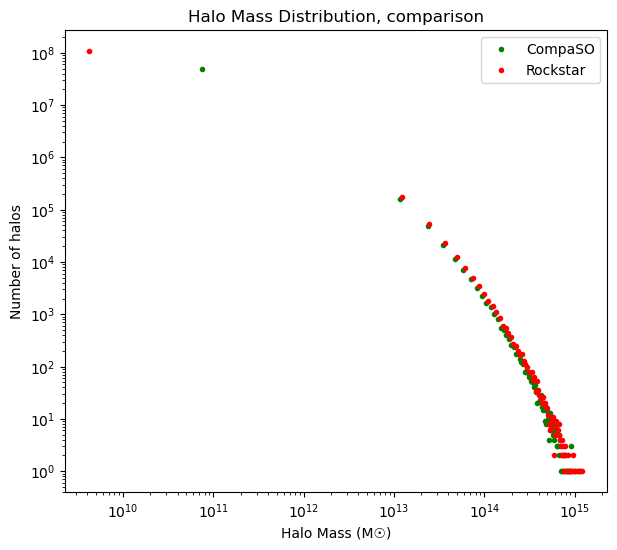

In [16]:
masses = [Mhalos_filtered_CS, Mhalos_filtered_RS]
print_sample_mass_distribution(masses, labels_name, colors=colors_list, title='comparison')

In [17]:
threshold = 1e10
Mhalos_filtered_RS_fil = filter_mass(Mhalos_filtered_RS,threshold)
Mhalos_filtered_CS_fil = filter_mass(Mhalos_filtered_CS,threshold)

# Linear bins
bins = np.histogram_bin_edges(np.concatenate([Mhalos_filtered_RS_fil, Mhalos_filtered_CS_fil]), bins=50)

# Logarithmic bins
min_mass = max(Mhalos_filtered_RS.min(), Mhalos_filtered_CS.min())
max_mass = max(Mhalos_filtered_RS.max(), Mhalos_filtered_CS.max())
bins_log = np.logspace(np.log10(min_mass), np.log10(max_mass), num=50)

# Rockstar total masses
mass_sums_rs_log = compute_mass_sums(Mhalos_filtered_RS, bins_log)
mass_sums_rs = compute_mass_sums(Mhalos_filtered_RS, bins)

# CompaSO total masses
mass_sums_cs_log = compute_mass_sums(Mhalos_filtered_CS, bins_log)
mass_sums_cs = compute_mass_sums(Mhalos_filtered_CS, bins)

# Relativ difference
relative_diff_log, diff_log = compute_differences(mass_sums_rs_log, mass_sums_cs_log)
relative_diff, diff = compute_differences(mass_sums_rs, mass_sums_cs)

In [18]:
list_bins = [bins, bins_log]

In [19]:
print('Log \n')
print('Rockstar total mass for the 1st bin: ',mass_sums_rs_log[0], '\n')
print('CompaSO total mass for the 1st bin: ',mass_sums_cs_log[0], '\n')
print('log bins : ',bins_log, '\n')

print('Linear \n')
print('Rockstar total mass for the 1st bin: ',mass_sums_rs[0], '\n')
print('CompaSO total mass for the 1st bin: ',mass_sums_cs[0], '\n')
print('linear bins : ',bins, '\n')

Log 

Rockstar total mass for the 1st bin:  7.726089537742438e+17 

CompaSO total mass for the 1st bin:  5.792818320736813e+17 

log bins :  [7.38178532e+10 9.00230237e+10 1.09785701e+11 1.33886863e+11
 1.63278932e+11 1.99123417e+11 2.42836811e+11 2.96146570e+11
 3.61159374e+11 4.40444384e+11 5.37134765e+11 6.55051503e+11
 7.98854402e+11 9.74226229e+11 1.18809728e+12 1.44891927e+12
 1.76699928e+12 2.15490713e+12 2.62797206e+12 3.20488853e+12
 3.90845498e+12 4.76647478e+12 5.81285493e+12 7.08894602e+12
 8.64517631e+12 1.05430445e+13 1.28575501e+13 1.56801571e+13
 1.91224087e+13 2.33203348e+13 2.84398280e+13 3.46831992e+13
 4.22971724e+13 5.15826347e+13 6.29065266e+13 7.67163428e+13
 9.35578163e+13 1.14096484e+14 1.39143988e+14 1.69690149e+14
 2.06942083e+14 2.52371903e+14 3.07774892e+14 3.75340452e+14
 4.57738622e+14 5.58225592e+14 6.80772381e+14 8.30221762e+14
 1.01247964e+15 1.23474843e+15] 

Linear 

Rockstar total mass for the 1st bin:  2.8328222198299886e+19 

CompaSO total mass fo

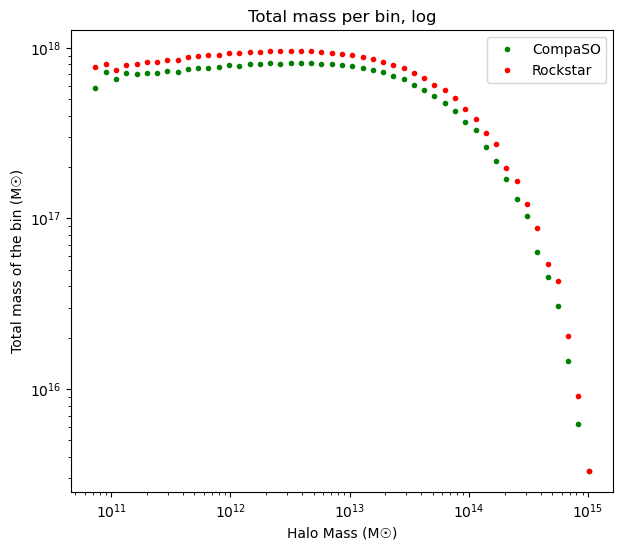

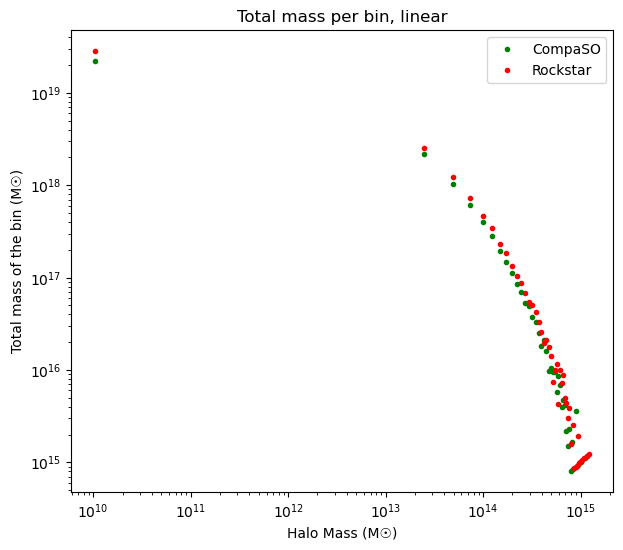

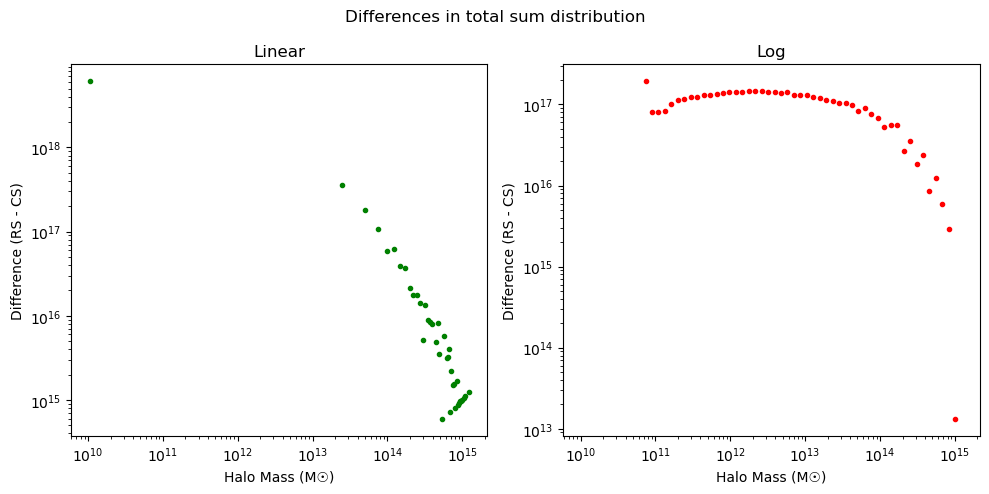

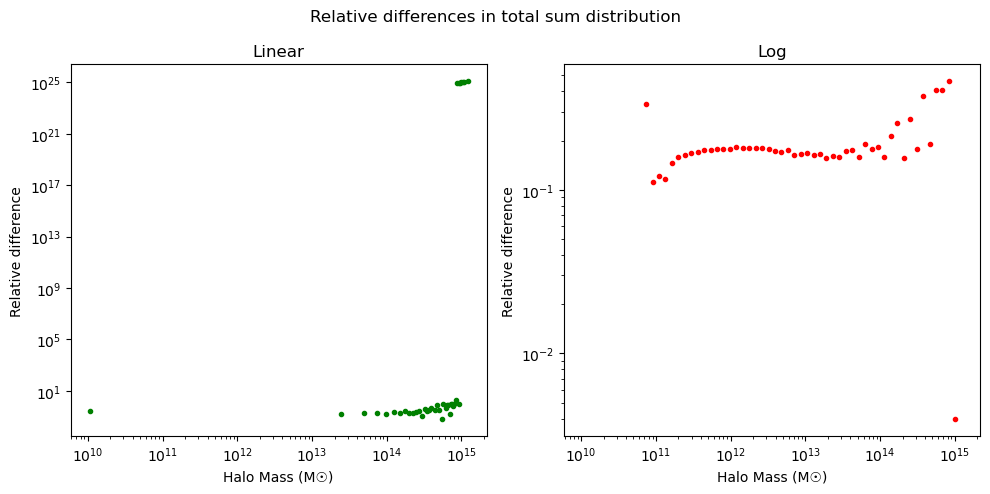

In [20]:
# Log bins
masses = [mass_sums_cs_log, mass_sums_rs_log]
print_total_mass(masses, bins_log, labels_name, colors_list, title='log')

# Linear bins
masses = [mass_sums_cs, mass_sums_rs]
print_total_mass(masses, bins, labels_name, colors_list, title='linear')

# Differences
diffs_sums = [diff, diff_log]
plot_loglog_bins(diffs_sums, list_bins, colors_list, labels_scale, title='Differences in total sum distribution', yname='Difference (RS - CS)')

relative_diffs_sums = [relative_diff, relative_diff_log]
plot_loglog_bins(relative_diffs_sums, list_bins, colors_list, labels_scale, title='Relative differences in total sum distribution', yname='Relative difference')


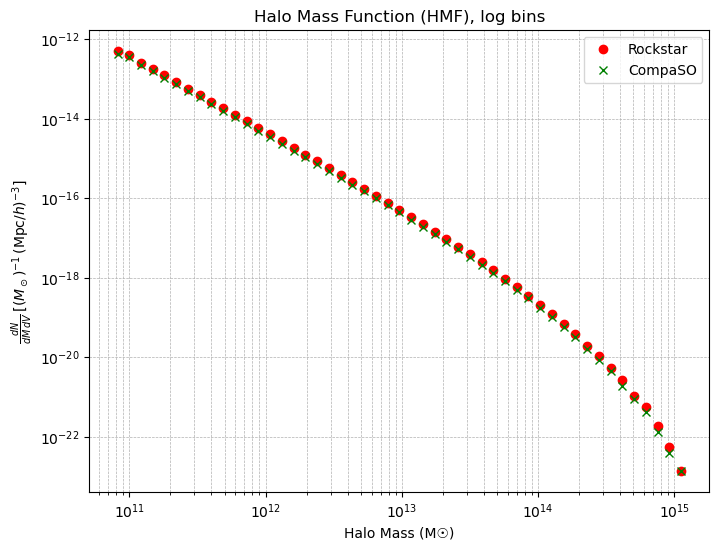

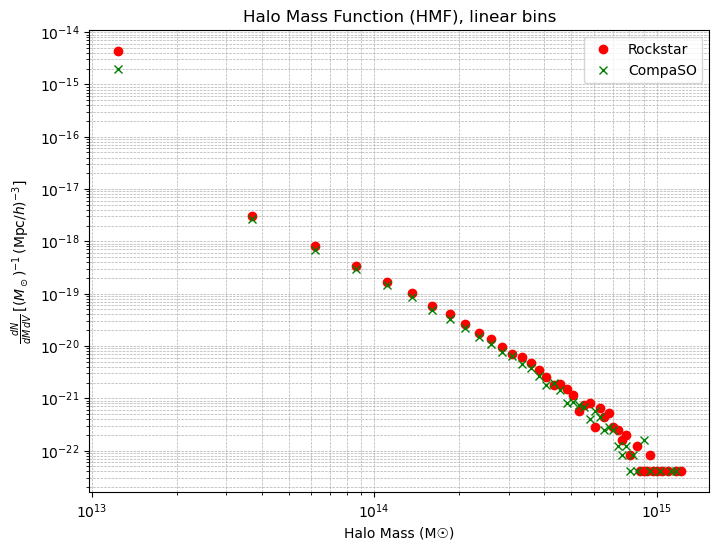

In [21]:
hmf_rs_log, bin_centers_rs_log = compute_hmf(Mhalos_filtered_RS_fil, bins_log, boxsize_rs)
hmf_cs_log, bin_centers_cs_log = compute_hmf(Mhalos_filtered_CS_fil, bins_log, boxsize_cs)

plt.figure(figsize=(8, 6))
plt.loglog(bin_centers_rs_log, hmf_rs_log, label='Rockstar', color='red', marker='o', linestyle='none')
plt.loglog(bin_centers_cs_log, hmf_cs_log, label='CompaSO', color='green', marker='x', linestyle='none')
plt.xlabel('Halo Mass (M☉)')
plt.ylabel(r'$\frac{dN}{dM \, dV} \, [(M_\odot)^{-1} \, (\mathrm{Mpc}/h)^{-3}]$')
plt.title('Halo Mass Function (HMF), log bins')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

hmf_rs, bin_centers_rs = compute_hmf(Mhalos_filtered_RS_fil, bins, boxsize_rs)
hmf_cs, bin_centers_cs = compute_hmf(Mhalos_filtered_CS_fil, bins, boxsize_cs)

plt.figure(figsize=(8, 6))
plt.loglog(bin_centers_rs, hmf_rs, label='Rockstar', color='red', marker='o', linestyle='none')
plt.loglog(bin_centers_cs, hmf_cs, label='CompaSO', color='green', marker='x', linestyle='none')
plt.xlabel('Halo Mass (M☉)')
plt.ylabel(r'$\frac{dN}{dM \, dV} \, [(M_\odot)^{-1} \, (\mathrm{Mpc}/h)^{-3}]$')
plt.title('Halo Mass Function (HMF), linear bins')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Rockstar - Mean mass : 3.22e+11, Standard deviation : 2.65e+12
CompaSO - Mean mass : 5.72e+11, Standard deviation : 3.58e+12


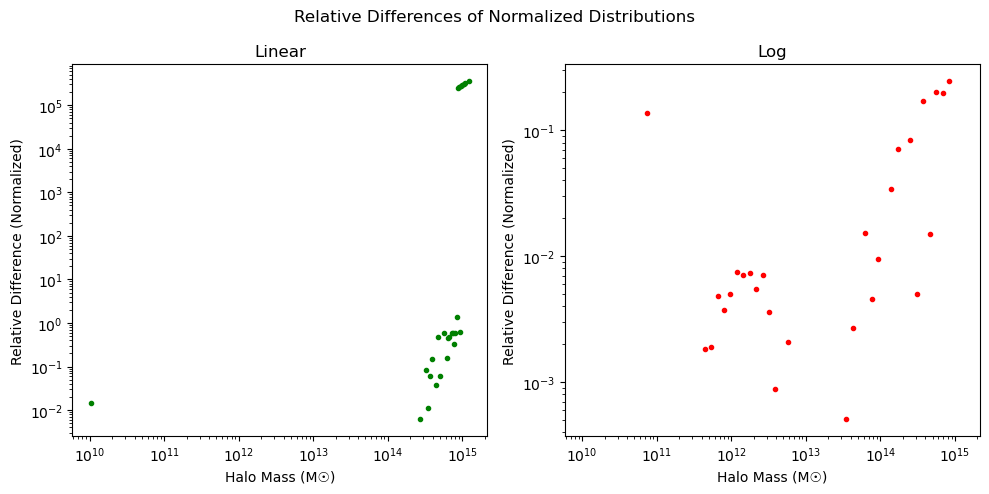

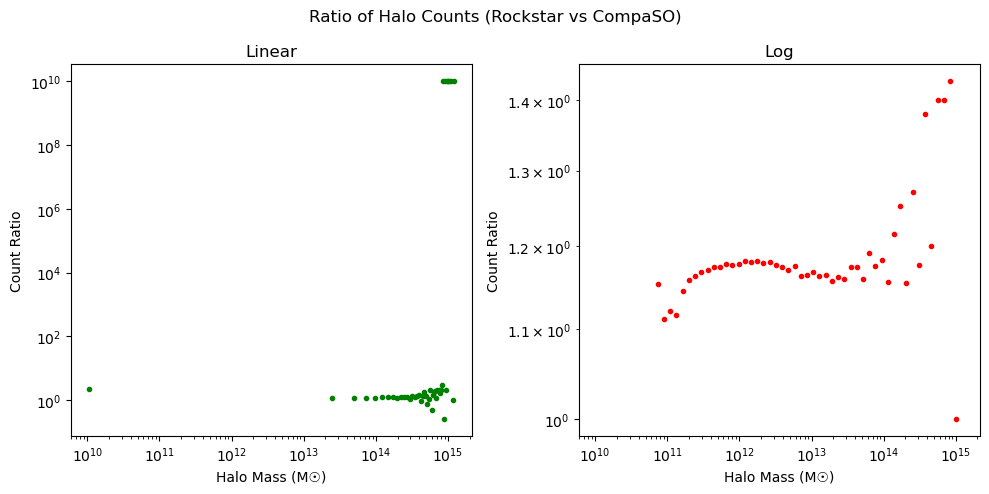

In [22]:
# Mean and standard deviation comparison
mean_mass_rs, std_mass_rs = calculate_stats(Mhalos_filtered_RS, "Rockstar")
mean_mass_cs, std_mass_cs = calculate_stats(Mhalos_filtered_CS, "CompaSO")

# Normalised distribution
mass_sums_rs_norm = normalize_distribution(mass_sums_rs)
mass_sums_cs_norm = normalize_distribution(mass_sums_cs)
mass_sums_rs_norm_log = normalize_distribution(mass_sums_rs_log)
mass_sums_cs_norm_log = normalize_distribution(mass_sums_cs_log)

# Linear
relative_diff_norm, diff_norm = compute_differences(mass_sums_rs_norm, mass_sums_cs_norm)
# Log
relative_diff_norm_log, diff_norm_log = compute_differences(mass_sums_rs_norm_log, mass_sums_cs_norm_log)

# Plot results
diffs = [relative_diff_norm, relative_diff_norm_log]
plot_loglog_bins(diffs, list_bins, colors_list, labels_scale, title='Relative Differences of Normalized Distributions', yname='Relative Difference (Normalized)')

# Ratio count, linear
counts_rs, _ = np.histogram(Mhalos_filtered_RS, bins=bins)
counts_cs, _ = np.histogram(Mhalos_filtered_CS, bins=bins)
# Ratio count, log
counts_rs_log, _ = np.histogram(Mhalos_filtered_RS, bins=bins_log)
counts_cs_log, _ = np.histogram(Mhalos_filtered_CS, bins=bins_log)

ratio = ratio_counts(counts_rs, counts_cs) 
ratio_log = ratio_counts(counts_rs_log, counts_cs_log) 

ratios = [ratio, ratio_log]
plot_loglog_bins(ratios, list_bins, colors_list, labels_scale, title='Ratio of Halo Counts (Rockstar vs CompaSO)', yname='Count Ratio')

In [23]:
# Check empty bins in mass, linear
data_bins = [mass_sums_rs, mass_sums_rs_log, mass_sums_cs, mass_sums_cs_log]
labels_bins = ['Rockstar, linear',
               'Rockstar, log',
               'CompaSO, linear',
               'CompaSO, log']
title_bins = 'Bins of null mass'
bins_empty_rs, bins_empty_rs_log, bins_empty_cs, bins_empty_cs_log = check_empty_bins(data_bins, labels_bins, title_bins)

data_bins2 = [counts_rs, counts_rs_log, counts_cs, counts_cs_log]
labels_bins2 = ['Rockstar, linear', 
                'Rockstar, log',
                'CompaSO, linear',
                'CompaSO, log']
title_bins2 = 'Empty bins'
bins_zero_count_rs, bins_zero_count_rs_los, bins_zero_count_cs, bins_zero_count_cs_log = check_empty_bins(data_bins2, labels_bins2, title_bins2)


 Bins of null mass : 

Rockstar, linear : [33 41 43 45 46 48]
Rockstar, log : []
CompaSO, linear : [35 37 39 40 42 43 44 46 48 49]
CompaSO, log : []

 Empty bins : 

Rockstar, linear : [33 41 43 45 46 48]
Rockstar, log : []
CompaSO, linear : [35 37 39 40 42 43 44 46 48 49]
CompaSO, log : []


## Study of the correlation function

### 10% sample take

In [24]:
sampled_indices_cs = sample_take(id=hcat_filtered['id'], mass=Mhalos_filtered_CS, percent=0.1)
sampled_masses_cs = Mhalos_filtered_CS[sampled_indices_cs]
sampled_halos_cs = hcat_filtered[sampled_indices_cs]

# Afficher l'échantillon obtenu
print(f"CompaSO : Sample of {len(sampled_halos_cs):,} halos. \n")

sampled_indices_rs = sample_take(id=ids_filtered_RS, mass=Mhalos_filtered_RS, percent=0.1)
sampled_masses_rs = Mhalos_filtered_RS[sampled_indices_rs]
sampled_ids_rs = ids_filtered_RS[sampled_indices_rs]
sampled_positions_rs = positions_RS[sampled_indices_rs]
sampled_velocities_rs = velocities_RS[sampled_indices_rs]

print(f"Rockstar : Sample of {len(sampled_indices_rs):,} halos. \n")

CompaSO : Sample of 4,836,361 halos. 

Rockstar : Sample of 10,796,675 halos. 



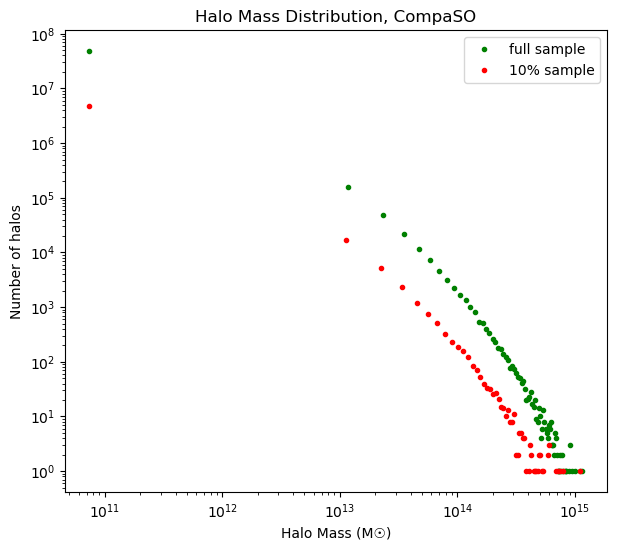

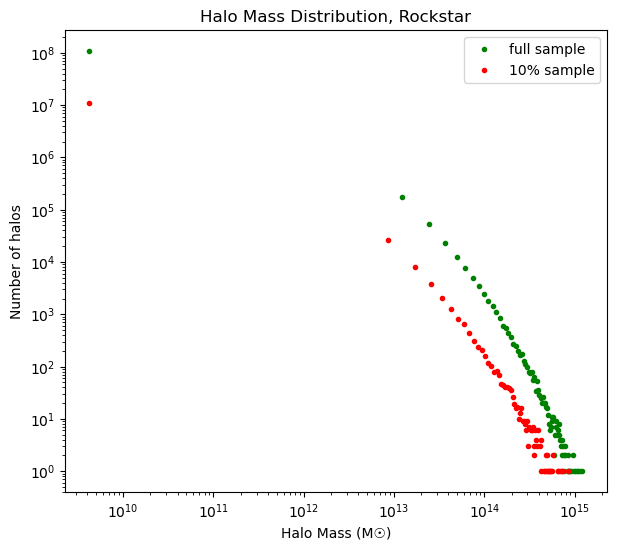

In [25]:
labels = ['full sample', '10% sample']

mass_samples_cs = [Mhalos_filtered_CS, sampled_masses_cs]
print_sample_mass_distribution(mass_samples_cs, labels, colors=colors_list, title='CompaSO')

mass_samples_rs = [Mhalos_filtered_RS, sampled_masses_rs]
print_sample_mass_distribution(mass_samples_rs, labels, colors=colors_list, title='Rockstar')

### Positions

In [26]:
positions_cs = np.array(sampled_halos_cs['x_L2com'])
positions_cs = positions_cs.astype(np.float64)
print("Shape of positions:", positions_cs.shape)
x_cs, y_cs, z_cs = positions_cs[:, 0], positions_cs[:, 1], positions_cs[:, 2]

Shape of positions: (4836361, 3)


In [27]:
# positions_rs = positions_rs.astype(np.float64)
print("Shape of positions:", sampled_positions_rs.shape)
x_rs, y_rs, z_rs = sampled_positions_rs[:, 0], sampled_positions_rs[:, 1], sampled_positions_rs[:, 2]

Shape of positions: (10796675, 3)


### SMU

In [28]:
bins_s = np.linspace(0, 100, 51)  # Distance intervals in Mpc/h
bins_mu = np.linspace(-1, 1, 51)    # Angle cosine intervals

In [29]:
# CompaSO
# 2PCF Calculations
results_smu_cs = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_s, bins_mu),  # Distance markers for bins
    data_positions1=(x_cs, y_cs, z_cs),  # Halo positions
    boxsize=boxsize_cs,  
    los='z',
    nthreads=26
)

# Results
xi_cs = results_smu_cs.corr  # Values of 2PCF
rp_cs = results_smu_cs.sep  # Corresponding distances

print('Shape of s :', rp_cs.shape)  # Should be dimension (n,)
print(f'Shape of xi(s) : {xi_cs.shape}')

Shape of s : (50, 50)
Shape of xi(s) : (50, 50)


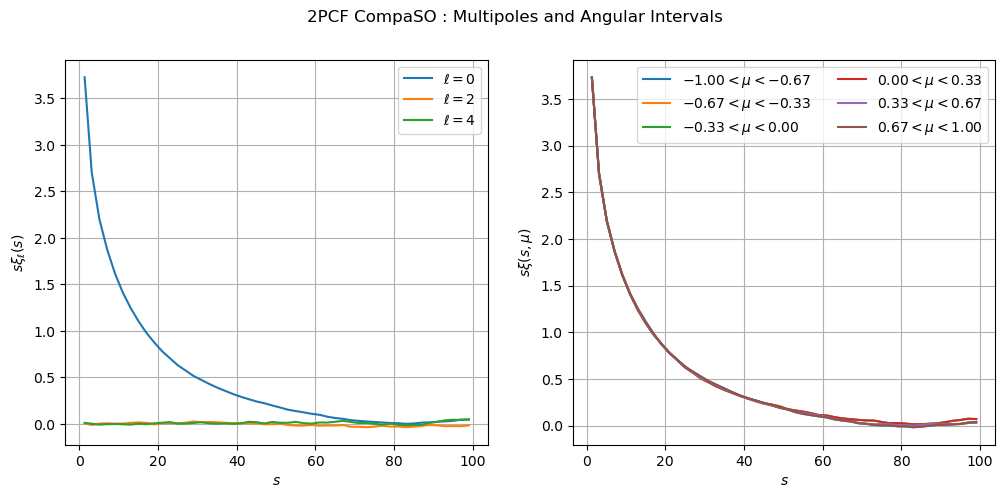

In [30]:
ells = (0, 2, 4)
wedges = (-1., -2./3, -1./3, 0., 1./3, 2./3, 1.)
print_multipoles(results_smu_cs, ells, wedges, title = 'CompaSO')

In [31]:
# 2PCF Calculations
results_smu_rs = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_s, bins_mu),  # Distance markers for bins
    data_positions1=(x_rs, y_rs, z_rs),  # Halo positions
    boxsize=boxsize_rs,  
    los='z',
    nthreads=26
)

# Results
xi_rs = results_smu_rs.corr  # Values of 2PCF
rp_rs = results_smu_rs.sep  # Corresponding distances

print('Shape of s :', rp_rs.shape)  # Should be dimension (n,)
print(f'Shape of xi(s) : {xi_rs.shape}')

Shape of s : (50, 50)
Shape of xi(s) : (50, 50)


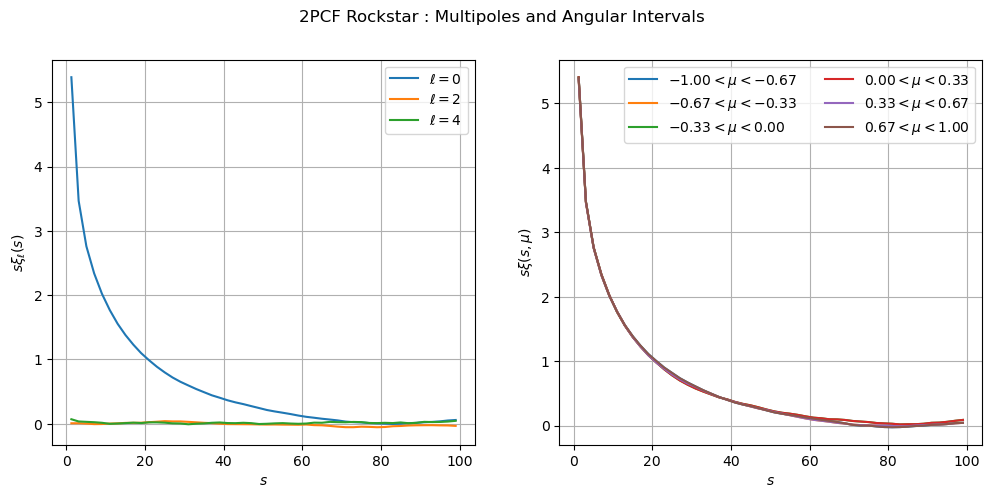

In [32]:
print_multipoles(results_smu_rs, ells, wedges, title = 'Rockstar')

### RPPI

In [33]:
bins_rp = np.linspace(0, 100, 101)  # (0,40,41)
bins_pi = np.linspace(-100, 100, 201)   # (-40,40,81)

In [34]:
# 2PCF Calculations
results_rppi_cs = TwoPointCorrelationFunction(
    mode='rppi',  
    edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
    data_positions1=(x_cs, y_cs, z_cs),  # Positions des halos
    nthreads=25,
    boxsize=boxsize_cs,
    los='z'
)

In [35]:
pi_cs = results_rppi_cs.sepavg(axis=1)
xi_rppi_cs = results_rppi_cs.corr

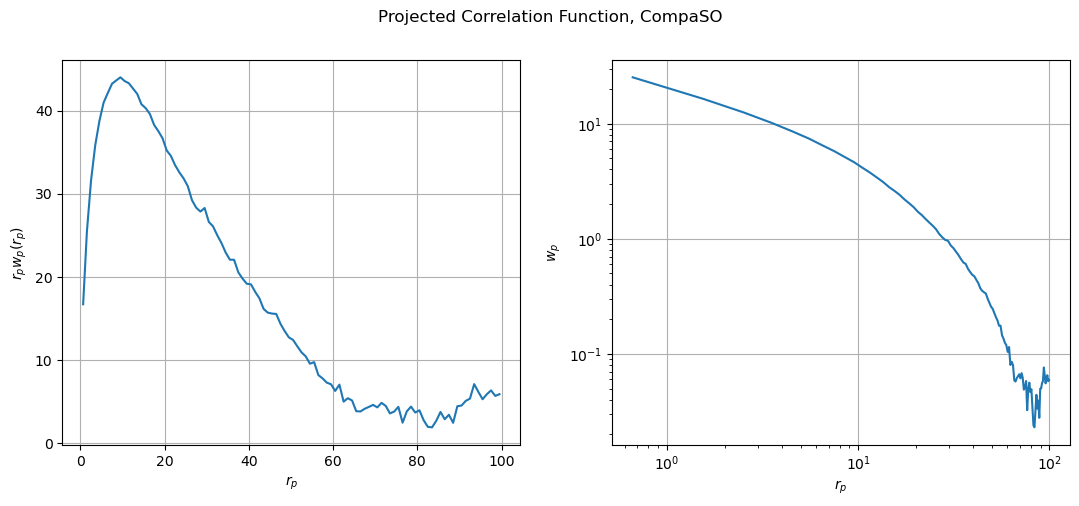

In [36]:
sep_cs = projected_pcf(results_rppi_cs, title='CompaSO')

In [37]:
print(sep_cs.shape)
print(pi_cs.shape)
print(pi_cs[100:].shape)
print(sep_cs[:100].shape)
print(xi_rppi_cs[:30, 100:-70].shape)
print(sep_cs[:30])
print(pi_cs[100:])

a = len(pi_cs) // 2
b = len(pi_cs) // 2 - 99
print(a, b)
print(pi_cs[a:-b])

(100,)
(200,)
(100,)
(100,)
(30, 30)
[ 0.66209586  1.55331527  2.53224756  3.52307925  4.51802948  5.51471315
  6.51250631  7.51088214  8.50960479  9.50856704 10.50774936 11.50703962
 12.50651604 13.50606757 14.50563545 15.50529475 16.50497065 17.50466989
 18.50445425 19.50419398 20.5039874  21.50381197 22.50363383 23.50349341
 24.50336099 25.50323427 26.5031245  27.50302913 28.5029134  29.50281252]
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5
 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5 67.5 68.5 69.5
 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5 80.5 81.5 82.5 83.5
 84.5 85.5 86.5 87.5 88.5 89.5 90.5 91.5 92.5 93.5 94.5 95.5 96.5 97.5
 98.5 99.5]
100 1
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 

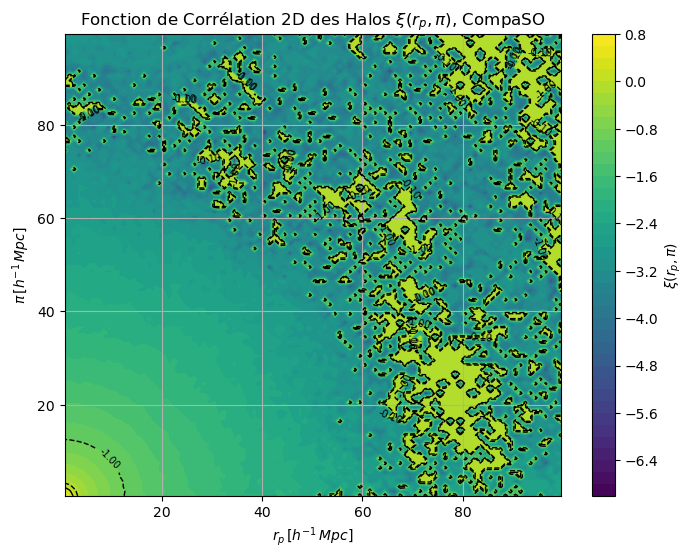

In [38]:
print_xi(results_rppi_cs, pi_lim=100, title='CompaSO')

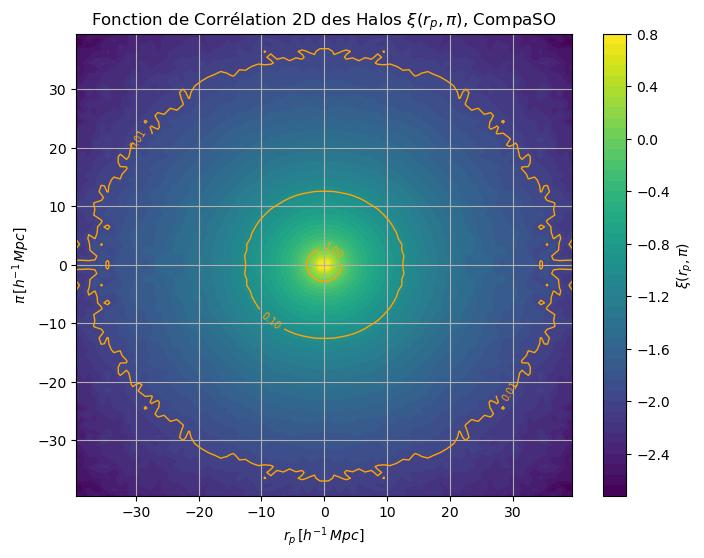

In [39]:
print_xi_round(results_rppi_cs, lim=60, title='CompaSO')

In [40]:
# 2PCF Calculations
results_rppi_rs = TwoPointCorrelationFunction(
    mode='rppi',  
    edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
    data_positions1=(x_rs, y_rs, z_rs),  # Positions des halos
    nthreads=25,
    boxsize=boxsize_cs,
    los='z'
)

In [41]:
pi_rs = results_rppi_rs.sepavg(axis=1)
xi_rppi_rs = results_rppi_rs.corr

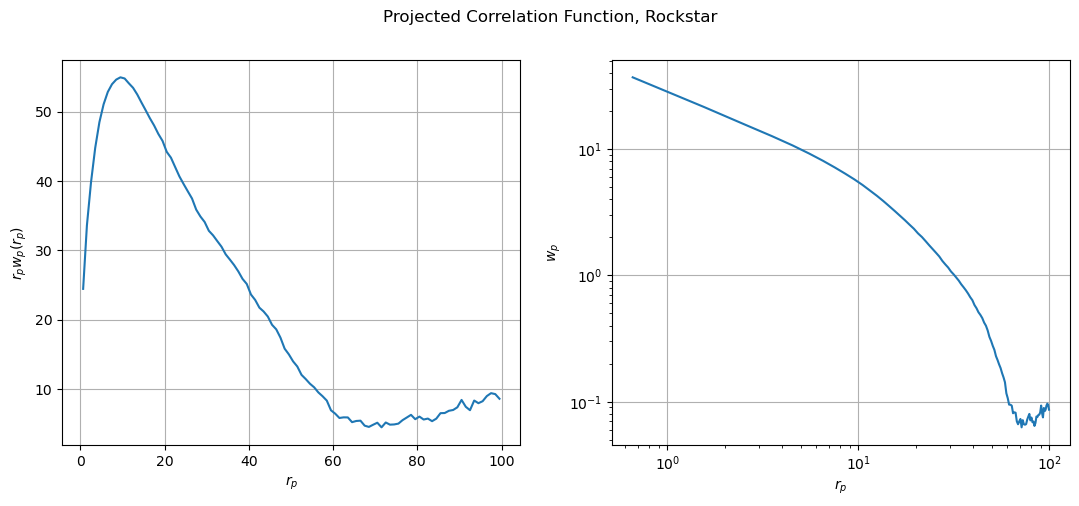

In [42]:
sep_rs = projected_pcf(results_rppi_rs, title='Rockstar')

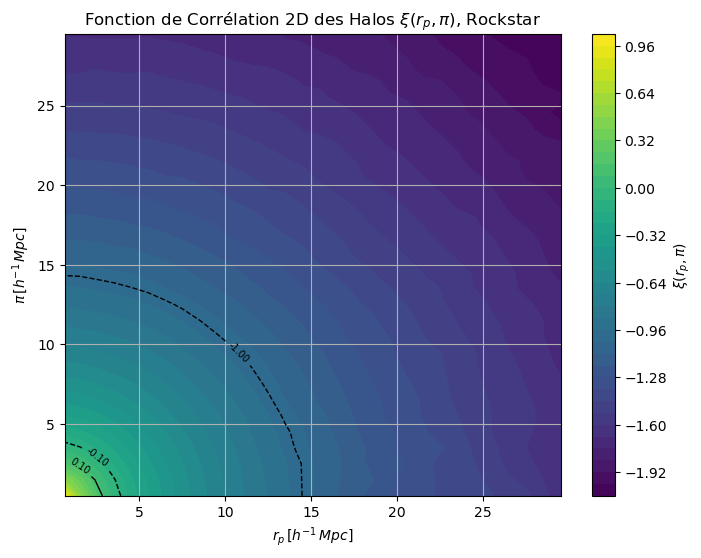

In [43]:
print_xi(results_rppi_rs, pi_lim=30, title='Rockstar')

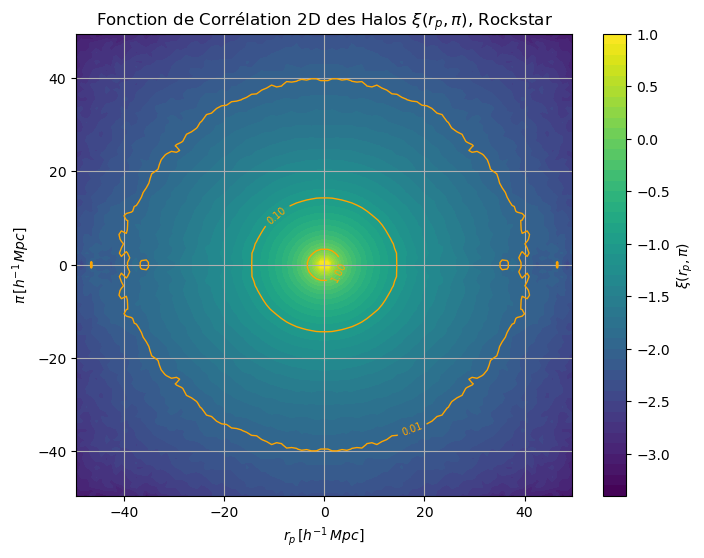

In [44]:
print_xi_round(results_rppi_rs, lim=50, title='Rockstar')

## RSD

Shape of velocities: (4836361, 3)
Shape of positions: (4836361, 3) 

Velocities:  [ 150.88782  257.98947  419.90796 ... -215.42285  270.91156  616.5188 ] [893.68207  873.9547   535.75836  ... 199.44908   65.445885  78.38909 ] [150.54753   44.617558 -27.124567 ... 204.62831  396.773    -70.59765 ] 

Hubble constant Hz: 132.23392151789199 

z: [-345.52954102 -338.10339355 -219.63023376 ...  -42.1519165   157.12345886
  282.33688354] 
 z rsd: [-343.82179987 -337.59727275 -219.93792224 ...  -39.83070827  161.6242671
  281.5360567 ] 

delta z : [ 1.70774114  0.5061208  -0.30768847 ...  2.32120824  4.50080824
 -0.80082685]


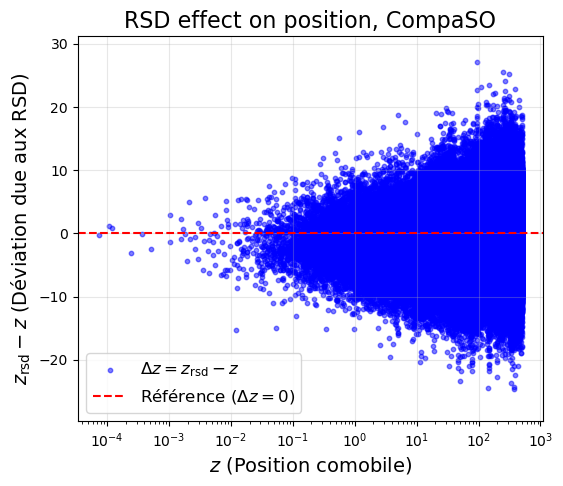

Hz : 131.54618960654088 
 Om_rs : 0.315192 
 Ol_rs : 0.666667 
 z_sim_rs : 0.5 
 a_rs : 0.666667 

Shape of velocities: (10796675, 3)
Shape of positions: (10796675, 3) 

Velocities:  [-640.60846   -84.00193   -54.880417 ...  280.87784    58.46533
  199.95372 ] [ 810.22687  916.15405 1040.9832  ... -300.8751  -324.12894 -212.3089 ] [ 175.51689   -44.158115 -146.52754  ... -313.37723  -231.9888
 -257.57565 ] 

Hubble constant Hz: 131.54618960654088 

z: [598.26105 598.67773 599.23114 ... 518.0166  498.99722 506.52475] 
 z rsd: [600.26245 598.1742  597.5603  ... 514.44324 496.3519  503.58765] 

delta z : [ 2.0014038  -0.50354004 -1.6708374  ... -3.5733643  -2.6453247
 -2.9371033 ]


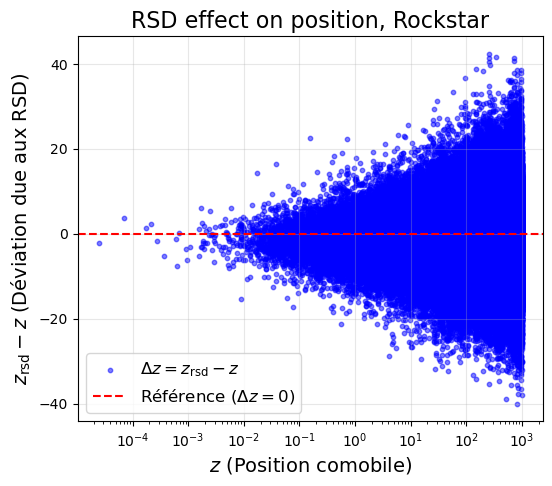

In [45]:
## CompaSO

z_sim_cs = hcat.header['Redshift']
id_cs = np.array(sampled_halos_cs['id'])
a_cs = hcat.header['ScaleFactor'] # scale factor

Hz_cs = hcat.header['HubbleNow'] * 100

velocities_cs = np.array(sampled_halos_cs['v_L2com'])

z_rsd_cs, delta_z_cs = rsd_effect(a_cs, positions_cs, velocities_cs, Hz_cs, name='CompaSO')

## Rockstar
H0 = 100
Om_rs = get_variable(file_path_rs, name='Om')
Ol_rs = get_variable(file_path_rs, name='Ol')
z_sim_rs = extract_redshift_from_path(file_path_rs)
a_rs = Ol_rs = get_variable(file_path_rs, name='SCALE_NOW')

Hz_rs = H0 * np.sqrt(Om_rs * (1+z_sim_rs)**3 + Ol_rs)

print('Hz :', Hz_rs, '\n', 'Om_rs :', Om_rs, '\n', 'Ol_rs :', Ol_rs, '\n', 'z_sim_rs :', z_sim_rs, '\n', 'a_rs :', a_rs, '\n',)

z_rsd_rs, delta_z_rs = rsd_effect(a_rs, sampled_positions_rs, sampled_velocities_rs, Hz_rs, name='Rockstar')


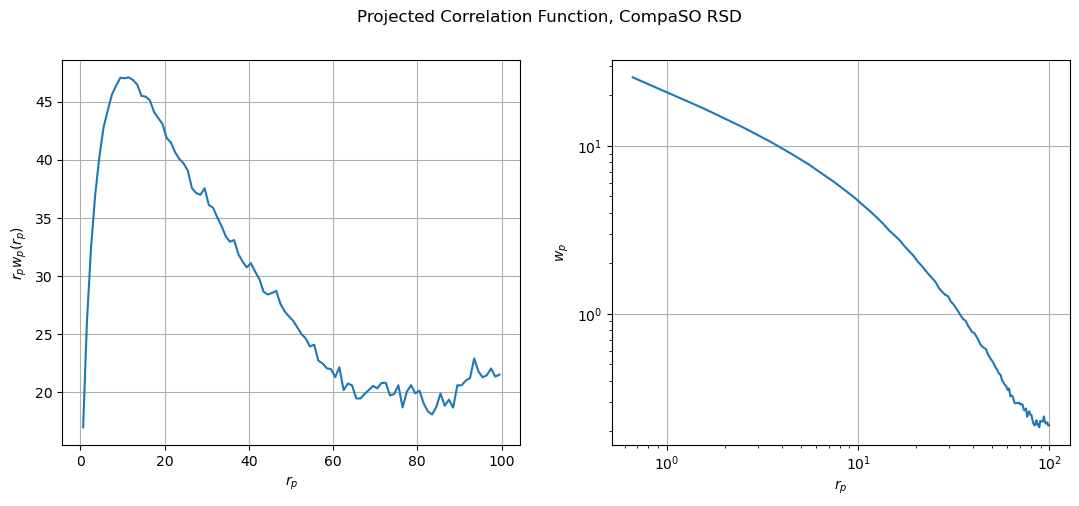

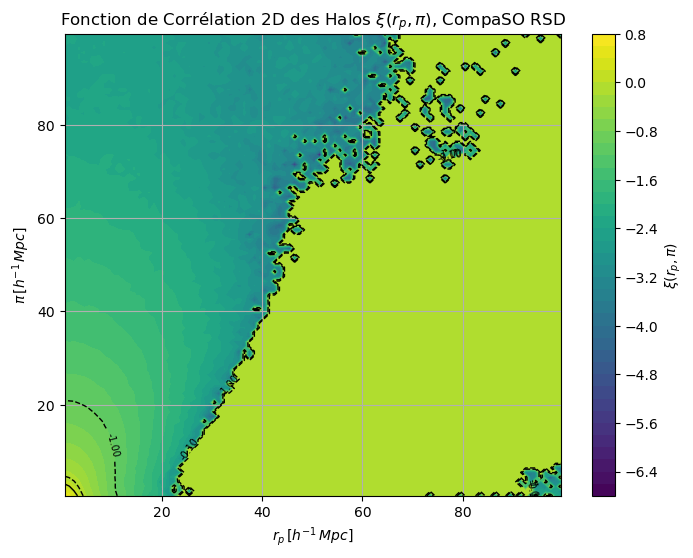

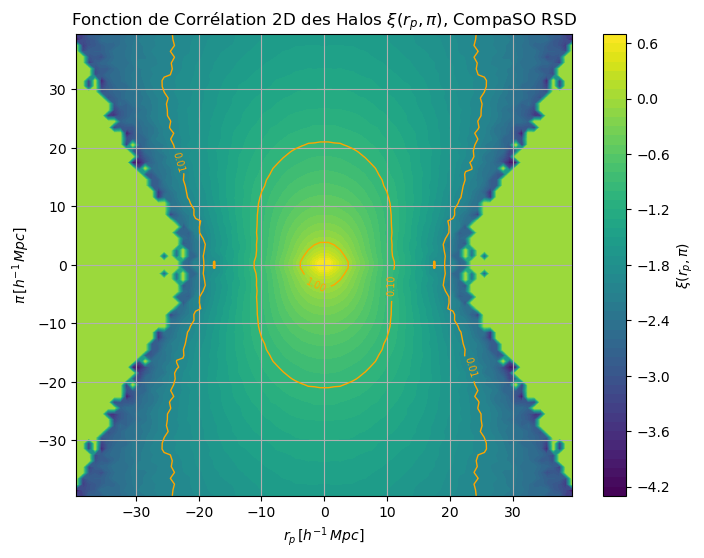

In [46]:
# 2PCF Calculations
results_rppi_cs_rsd = TwoPointCorrelationFunction(
    mode='rppi',  
    edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
    data_positions1=(x_cs, y_cs, z_rsd_cs),  # Positions des halos
    nthreads=25,
    boxsize=boxsize_cs,
    los='z'
)

pi_cs_rsd = results_rppi_cs_rsd.sepavg(axis=1)
xi_rppi_cs_rsd = results_rppi_cs_rsd.corr

sep_cs_rsd = projected_pcf(results_rppi_cs_rsd, title='CompaSO RSD')

print_xi(results_rppi_cs_rsd, pi_lim=100, title='CompaSO RSD')

print_xi_round(results_rppi_cs_rsd, lim=60, title='CompaSO RSD')

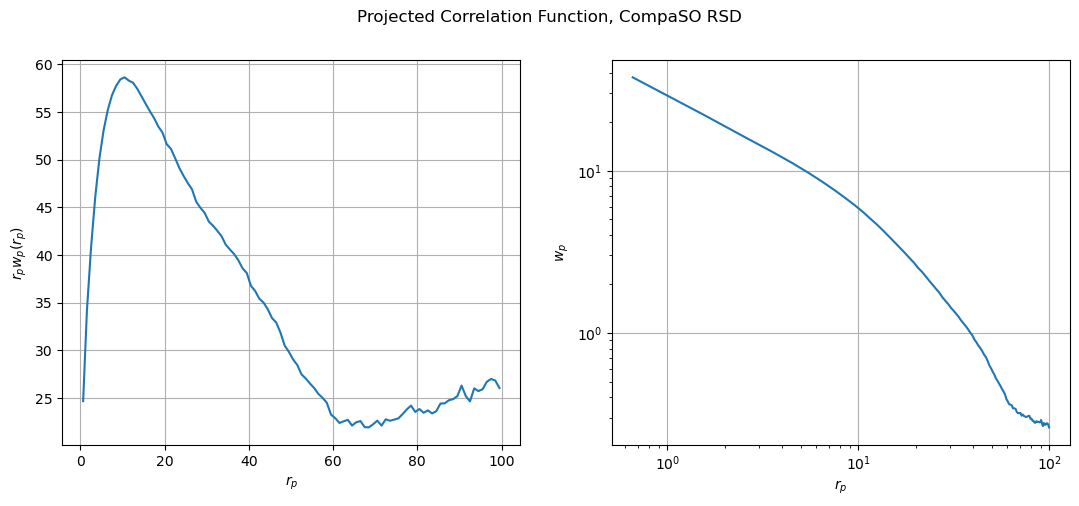

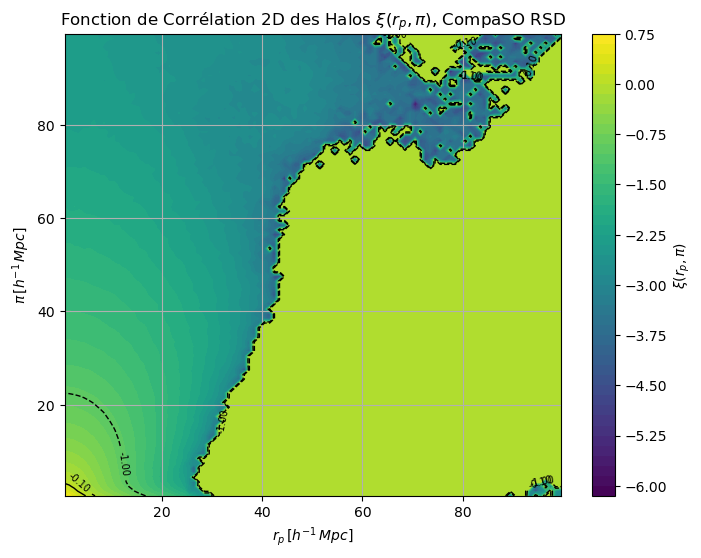

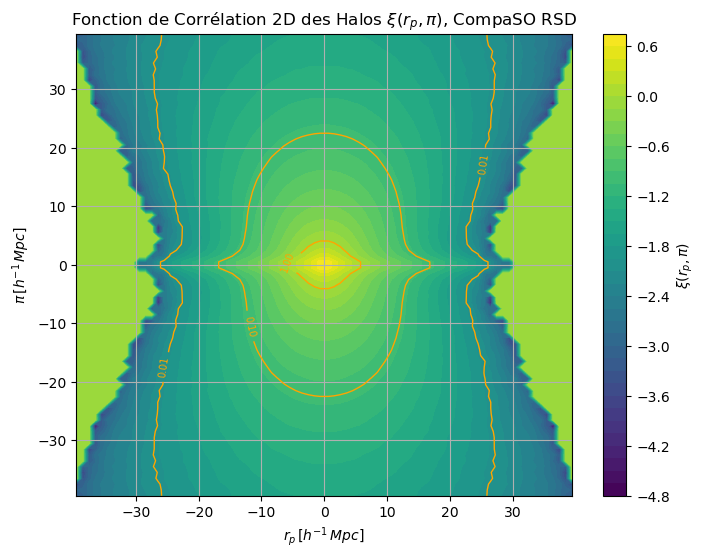

In [47]:
# 2PCF Calculations
results_rppi_rs_rsd = TwoPointCorrelationFunction(
    mode='rppi',  
    edges=(bins_rp, bins_pi),  # Bornes des distances pour les bins
    data_positions1=(x_rs, y_rs, z_rsd_rs),  # Positions des halos
    nthreads=25,
    boxsize=boxsize_rs,
    los='z'
)

pi_rs_rsd = results_rppi_rs_rsd.sepavg(axis=1)
xi_rppi_rs_rsd = results_rppi_rs_rsd.corr

sep_rs_rsd = projected_pcf(results_rppi_rs_rsd, title='CompaSO RSD')

print_xi(results_rppi_rs_rsd, pi_lim=100, title='CompaSO RSD')

print_xi_round(results_rppi_rs_rsd, lim=60, title='CompaSO RSD')


## Bias

### CompaSO

In [48]:
fraction = 0.01  # 10% of the data

# Create a binary mask to select 10% of the data
mask = np.random.rand(positions_cs_mm.shape[0]) < fraction

# Apply the mask
positions_cs_mm_sampled = positions_cs_mm[mask]

In [49]:
if positions_cs_mm_sampled.shape[1] == 3:  # Check that it's a 2D table with 3 columns
    positions_cs_mm_sampled = [positions_cs_mm_sampled[:, 0], positions_cs_mm_sampled[:, 1], positions_cs_mm_sampled[:, 2]]  # Separate x, y, z

In [50]:
# xi_mm

results_smu_mm_cs = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_s, bins_mu),  # Distance markers for bins
    data_positions1=positions_cs_mm_sampled,  # Particles positions
    boxsize=boxsize_cs,  
    los='z',
    nthreads=32
)

In [51]:
xi_cs_mm = results_smu_mm_cs.corr

r_cs_mono, xi_cs_mono = results_smu_cs(ells=(0,), return_sep=True)
r_cs_mm_mono, xi_cs_mm_mono = results_smu_mm_cs(ells=(0,), return_sep=True)

In [52]:
print(f"xi_cs_mono shape: {xi_cs_mono.shape}")
print(f"xi_cs_mm_mono shape: {xi_cs_mm_mono.shape}")
print(f"xi_cs_mm shape: {xi_cs_mm.shape}")
print(f"r_cs_mm_mono shape: {r_cs_mm_mono.shape}")
print(f"r_cs_mono shape: {r_cs_mono.shape}")

xi_cs_mono shape: (1, 50)
xi_cs_mm_mono shape: (1, 50)
xi_cs_mm shape: (50, 50)
r_cs_mm_mono shape: (50,)
r_cs_mono shape: (50,)


In [53]:
print(f"r_cs_mm_mono : {r_cs_mm_mono} \n")
print(f"r_cs_mono : {r_cs_mono}")

r_cs_mm_mono : [ 1.39316911  3.16602093  5.11286373  7.0848654   9.067975   11.05668835
 13.04859672 15.04256649 17.03780787 19.03403007 21.03094622 23.02834379
 25.02614941 27.02430592 29.02266577 31.02125343 33.01997864 35.01886474
 37.01785366 39.01695967 41.01615665 43.01540459 45.01472247 47.01410292
 49.01353421 51.01301464 53.01253339 55.01208083 57.01165347 59.01126375
 61.01089176 63.01054662 65.01023482 67.00992992 69.00963839 71.00937545
 73.00911975 75.00888335 77.0086481  79.00843679 81.00822383 83.00802958
 85.00785055 87.00766606 89.00750113 91.00733354 93.00717704 95.00702775
 97.00687852 99.0067373 ] 

r_cs_mono : [ 1.33637359  3.14701396  5.10350987  7.07944382  9.06473006 11.05466651
 13.04724324 15.04150543 17.03711558 19.03351396 21.03048636 23.02808963
 25.02584574 27.02403944 29.02242753 31.02105859 33.01985138 35.01870051
 37.01776679 39.01691279 41.01609305 43.01538728 45.01467945 47.01403833
 49.01348239 51.01297098 53.01251671 55.01206859 57.0116415  59.01126

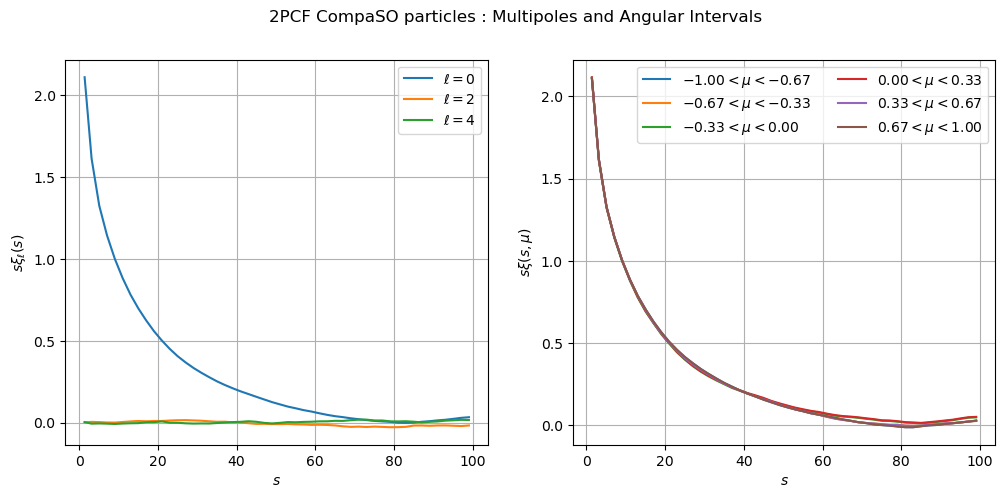

In [54]:
print_multipoles(results_smu_mm_cs, ells, wedges, title = 'CompaSO particles')

[  1.8404027    1.68467839   1.66061091   1.63698191   1.6137477
   1.59671038   1.59026343   1.57910837   1.56583101   1.5659652
   1.55557618   1.56205316   1.54833085   1.55147884   1.53531148
   1.54374139   1.53796486   1.53846282   1.53928043   1.52567819
   1.517373     1.51449698   1.51596966   1.55827516   1.56651454
   1.56534709   1.53762902   1.55296308   1.60177995   1.57124074
   1.68144584   1.58786084   1.56066529   1.56515135   1.44685249
   1.44637969   1.54544158   1.73894234   1.70569495   1.6627497
 115.75894099   0.51354866   5.91209497   2.22403286   1.64427164
   1.50146295   1.47433723   1.34641985   1.50029108   1.37600733]


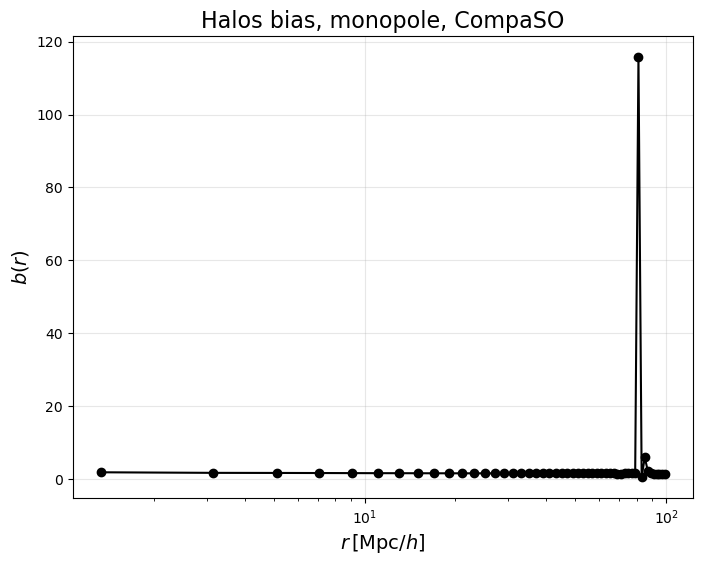

In [55]:
# Bias calculation
bias_cs = (xi_cs_mono / xi_cs_mm_mono).squeeze()

print(bias_cs)

plt.figure(figsize=(8, 6))
plt.semilogx(r_cs_mono, bias_cs,  marker='o', color='black')
plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
plt.ylabel(r'$b(r)$', fontsize=14)
plt.title('Halos bias, monopole, CompaSO', fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

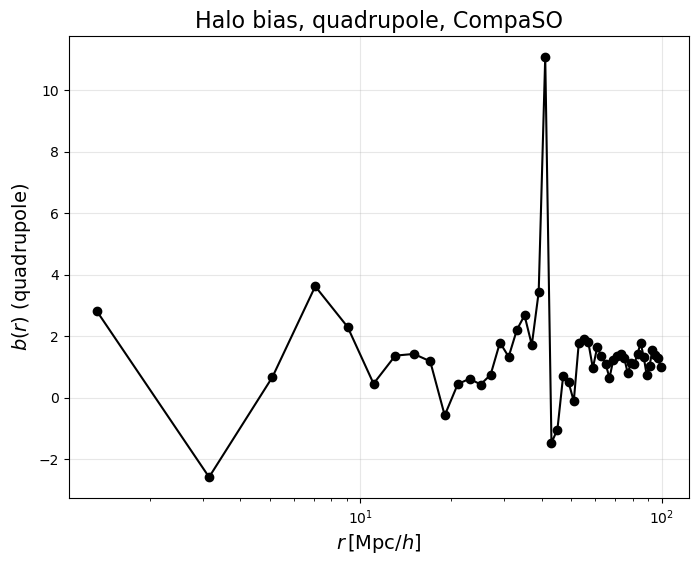

In [56]:
r_cs_quad, xi_cs_quad = results_smu_cs(ells=(2,), return_sep=True)
r_cs_mm_quad, xi_cs_mm_quad = results_smu_mm_cs(ells=(2,), return_sep=True)

# Calcul du biais pour le quadrupôle
bias_quad = (xi_cs_quad / xi_cs_mm_quad).squeeze()

# Tracé du biais quadrupolaire
plt.figure(figsize=(8, 6))
plt.semilogx(r_cs_quad, bias_quad, marker='o', color='black')
plt.xlabel(r'$r \, [\mathrm{Mpc}/h]$', fontsize=14)
plt.ylabel(r'$b(r)$ (quadrupole)', fontsize=14)
plt.title('Halo bias, quadrupole, CompaSO', fontsize=16)
plt.grid(True, alpha=0.3)
plt.show()

In [57]:
# mass_bins = np.logspace(11, np.log10(2 * 10**15), 16)

mass_bins = np.logspace(11, 15, 12) 
print(mass_bins)

new_mass_bins = list(mass_bins[:9])  # Conserver les bins jusqu'au 10 inclus
new_mass_bins.append(mass_bins[11])  # Fusionner les bins 11, 12, 13 en un seul bin final 
new_mass_bins = np.array(new_mass_bins)  # Convertir en tableau numpy pour compatibilité

print(f"New mass bins: {new_mass_bins}")

[1.00000000e+11 2.31012970e+11 5.33669923e+11 1.23284674e+12
 2.84803587e+12 6.57933225e+12 1.51991108e+13 3.51119173e+13
 8.11130831e+13 1.87381742e+14 4.32876128e+14 1.00000000e+15]
New mass bins: [1.00000000e+11 2.31012970e+11 5.33669923e+11 1.23284674e+12
 2.84803587e+12 6.57933225e+12 1.51991108e+13 3.51119173e+13
 8.11130831e+13 1.00000000e+15]


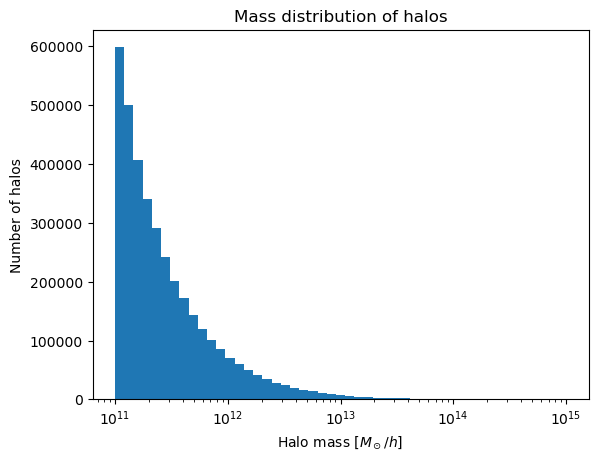

In [58]:
plt.hist(sampled_masses_cs, bins=np.logspace(11, 15, 50))
plt.xscale('log')
plt.xlabel("Halo mass [$M_\odot / h$]")
plt.ylabel("Number of halos")
plt.title("Mass distribution of halos")
plt.show()

In [59]:
samp_masses_cs = np.array(sampled_masses_cs)

# Nombre de bins souhaité
n_bins = 10

# Calculer les quantiles
quantiles = np.percentile(samp_masses_cs, np.linspace(0, 100, n_bins + 1))

# Afficher les limites des bins
print("Quantiles (bin edges):", quantiles)

# Vérifier le nombre de halos dans chaque bin
for i in range(len(quantiles) - 1):
    mask = (samp_masses_cs >= quantiles[i]) & (samp_masses_cs < quantiles[i + 1])
    print(f"Bin {i}: {np.sum(mask)} halos")

# Extraire les limites des bins
bins = [(quantiles[i], quantiles[i + 1]) for i in range(len(quantiles) - 1)]

# Afficher les bins
for i, (low, high) in enumerate(bins):
    print(f"Bin {i}: [{low:.2e}, {high:.2e}]")

Quantiles (bin edges): [7.38178532e+10 8.22541793e+10 9.27995869e+10 1.07563158e+11
 1.26544891e+11 1.51853869e+11 1.91926418e+11 2.61526109e+11
 3.98616407e+11 8.16214548e+11 1.12021334e+15]
Bin 0: 443070 halos
Bin 1: 467798 halos
Bin 2: 516995 halos
Bin 3: 489327 halos
Bin 4: 472366 halos
Bin 5: 493481 halos
Bin 6: 498004 halos
Bin 7: 483529 halos
Bin 8: 487802 halos
Bin 9: 483988 halos
Bin 0: [7.38e+10, 8.23e+10]
Bin 1: [8.23e+10, 9.28e+10]
Bin 2: [9.28e+10, 1.08e+11]
Bin 3: [1.08e+11, 1.27e+11]
Bin 4: [1.27e+11, 1.52e+11]
Bin 5: [1.52e+11, 1.92e+11]
Bin 6: [1.92e+11, 2.62e+11]
Bin 7: [2.62e+11, 3.99e+11]
Bin 8: [3.99e+11, 8.16e+11]
Bin 9: [8.16e+11, 1.12e+15]


In [60]:
if np.any(xi_cs_mm_mono < 0):
    print("Valeurs négatives détectées dans xi")
    print("Indices et valeurs négatives :", np.where(xi_cs_mm_mono < 0), xi_cs_mm_mono[xi_cs_mm_mono < 0])

Valeurs négatives détectées dans xi
Indices et valeurs négatives : (array([0]), array([41])) [-1.1433476e-05]


In [61]:
bias_by_mass = []

# for i in range(len(bins) - 1):
for i, (low, high) in enumerate(bins):
    # Take halos within this mass bin
    # mask = (sampled_masses_cs >= bins[i]) & (sampled_masses_cs < bins[i + 1])
    mask = (sampled_masses_cs >= low) & (sampled_masses_cs < high)
    halos_in_bin = positions_cs[mask]
    
    # Skip the bin if it is empty
    # if halos_in_bin.shape[0] == 0:
    #     print(f"Skipping bin {i} because it contains no halos.")
    #     continue

    print(f"Bin {i}: {halos_in_bin.shape[0]} halos")

    if halos_in_bin.shape[1] == 3:  # Check it is a 2D table with 3 coloums
        halos_in_bin = [halos_in_bin[:, 0], halos_in_bin[:, 1], halos_in_bin[:, 2]]  # Separate x, y, z

    results_hh = TwoPointCorrelationFunction(
        mode='smu',
        edges=(bins_s, bins_mu),
        data_positions1=halos_in_bin,
        boxsize=boxsize_cs,
        nthreads=32,
        los='z'
    )
    r_hh, xi_hh = results_hh(ells=(0,), return_sep=True)

    # Calculer le biais pour ce bin
    bias = xi_hh / xi_cs_mm_mono 
    bias_by_mass.append((np.mean(mass_bins[i:i+2]), np.mean(bias)))

Bin 0: 443070 halos
Bin 1: 467798 halos
Bin 2: 516995 halos


Bin 3: 489327 halos
Bin 4: 472366 halos
Bin 5: 493481 halos
Bin 6: 498004 halos
Bin 7: 483529 halos
Bin 8: 487802 halos
Bin 9: 483988 halos


In [62]:
print(np.shape(bias_by_mass))

(10, 2)


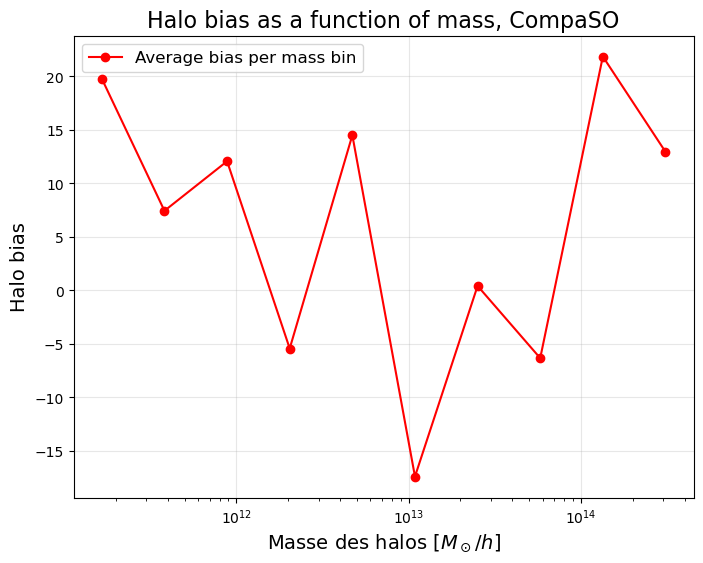

In [63]:
mass_centers = [item[0] for item in bias_by_mass]
bias_values = [item[1] for item in bias_by_mass]
bin_edges = [low for low, _ in bins] + [bins[-1][1]]

# mass_centers_clean = []
# bias_values_clean = []

# for mass, bias in zip(mass_centers, bias_values):
#     if bias > 0:  # Supposer qu'un biais positif est valide
#         mass_centers_clean.append(mass)
#         bias_values_clean.append(bias)

# Tracé du biais en fonction de la masse
plt.figure(figsize=(8, 6))
plt.semilogx(mass_centers, bias_values, marker='o', label='Average bias per mass bin', color='red')
plt.xlabel(r"Masse des halos [$M_\odot / h$]", fontsize=14)
plt.ylabel("Halo bias", fontsize=14)
plt.title("Halo bias as a function of mass, CompaSO", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

In [64]:
print(f"Mass centers: {mass_centers}")
print(f"Bias values: {bias_values}")

Mass centers: [165506485004.1579, 382341446564.473, 883258331281.3468, 2040441303938.934, 4713684057505.744, 10889221538052.508, 25155514085840.305, 58112500210560.08, 134247412682503.78, 310128935197172.44]
Bias values: [19.769413368493378, 7.434573995960212, 12.06180285595619, -5.425375331726338, 14.492294289030154, -17.38029600189192, 0.41977469295696607, -6.3249347315789795, 21.84174868338325, 12.945800285918326]


In [65]:
# Delta Sigma

results_gm = TwoPointCorrelationFunction(
    mode='smu',
    edges=(bins_s, bins_mu),
    data_positions1 = positions_cs_mm_sampled,
    data_positions2 = (x_cs, y_cs, z_cs),
    boxsize=boxsize_cs,
    nthreads=32,
    los='z'
)

In [66]:
r_vals, xi_gm = results_gm(ells=(0,), return_sep=True) 

/tmp/ipykernel_1243213/145313030.py:16: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(delta_sigma_integrand, r, max(r_vals), args=(r, xi_gm_interp), limit=1000, epsabs=1e-6, epsrel=1e-6)


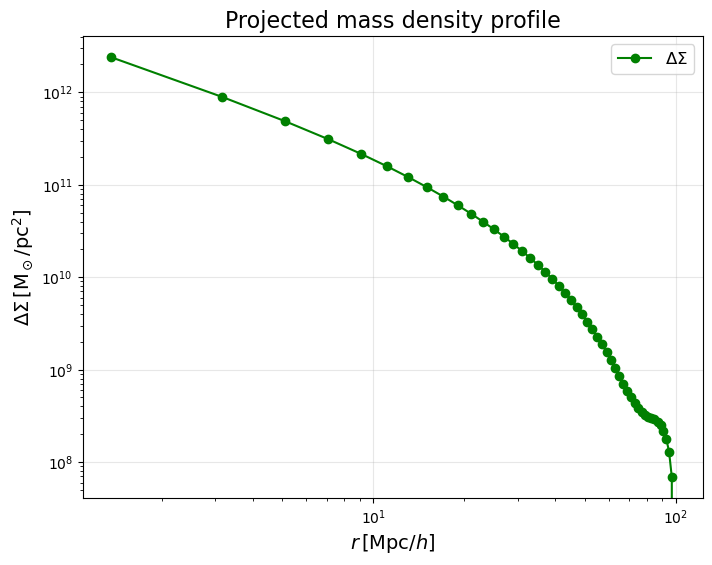

In [67]:
# Mean Universe density
Omega_m = get_variable("/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_highbase_c000_ph100//halos/z0.500/header", name='Omega_M')
rho_m = 2.775e11 * Omega_m

# Integration function
def delta_sigma_integrand(r_prime, r, xi_gm_interp):
    return xi_gm_interp(r_prime) * (r_prime / r)

# Interpolation of xi_gm
from scipy.interpolate import interp1d
xi_gm_interp = interp1d(r_vals, xi_gm, bounds_error=False, fill_value=0)

# Calcul of Delta Sigma for each r
delta_sigma = []
for r in r_vals:
    integral, _ = quad(delta_sigma_integrand, r, max(r_vals), args=(r, xi_gm_interp), limit=1000, epsabs=1e-6, epsrel=1e-6)
    delta_sigma.append(rho_m * integral)

# Convert to numpy table
delta_sigma = np.array(delta_sigma)

# Plot
plt.figure(figsize=(8, 6))
plt.loglog(r_vals, delta_sigma, marker='o', label=r'$\Delta \Sigma$', color='green')
plt.xlabel(r"$r \, [\mathrm{Mpc}/h]$", fontsize=14)
plt.ylabel(r"$\Delta \Sigma \, [\mathrm{M_\odot / pc^2}]$", fontsize=14)
plt.title("Projected mass density profile", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.show()

### Rockstar

In [68]:
x_file = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/z0.500_X_sorted.npy"
y_file = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/z0.500_Y_sorted.npy"
z_file = "/global/cfs/cdirs/desi/cosmosim/Abacus/supplemental/AbacusSummit_highbase_c000_ph100/rockstar/z0.500/z0.500_Z_sorted.npy"

x = np.load(x_file)
y = np.load(y_file)
z = np.load(z_file)

print(f"Dimensions : x = {x.shape}, y = {y.shape}, z = {z.shape}")

positions_rs_mm = np.vstack((x, y, z)).T
print(f"Tableau combiné : positions = {positions_rs_mm.shape}")

Dimensions : x = (93318302,), y = (93318302,), z = (93318302,)
Tableau combiné : positions = (93318302, 3)


In [69]:
fraction = 0.1  # Garder 10% des données

# Créez un masque binaire pour sélectionner environ 10% des données
mask = np.random.rand(positions_rs_mm.shape[0]) < fraction

# Appliquez le masque pour sous-échantillonner
positions_rs_mm_sampled = positions_rs_mm[mask]

In [70]:
if positions_rs_mm_sampled.shape[1] == 3:  # Vérifiez que c'est un tableau 2D avec 3 colonnes
    positions_rs_mm_sampled = [positions_rs_mm_sampled[:, 0], positions_rs_mm_sampled[:, 1], positions_rs_mm_sampled[:, 2]]  # Séparez x, y, z

In [71]:
# 2PCF Calculations
results_smu_mm_rs = TwoPointCorrelationFunction(
    mode='smu',  
    edges=(bins_s, bins_mu),  # Distance markers for bins
    data_positions1= positions_rs_mm_sampled,  # Halo positions
    boxsize=boxsize_rs,  
    los='z',
    nthreads=26
)

# Results
xi_mm_rs = results_smu_rs.corr  # Values of 2PCF
rp_mm_rs = results_smu_rs.sep  # Corresponding distances

print('Shape of s :', rp_mm_rs.shape)  # Should be dimension (n,)
print(f'Shape of xi(s) : {xi_mm_rs.shape}')

Shape of s : (50, 50)
Shape of xi(s) : (50, 50)


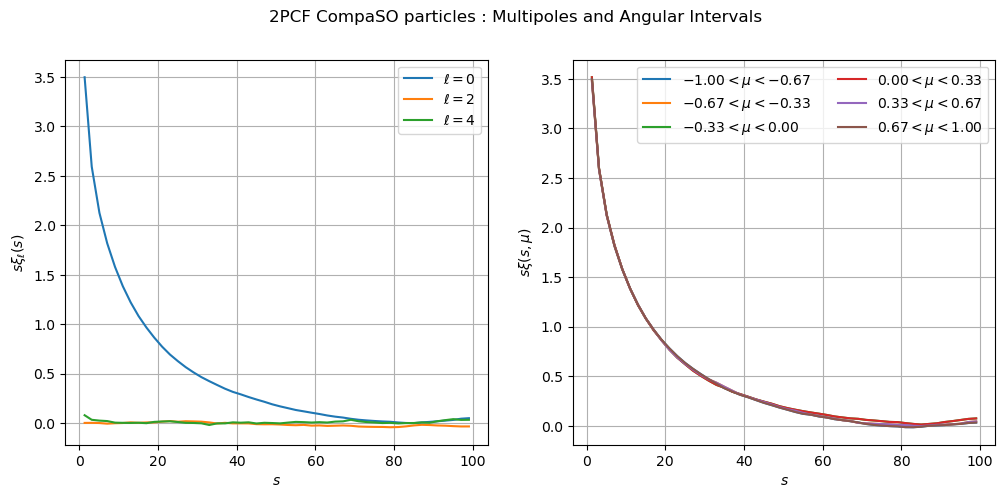

In [72]:
print_multipoles(results_smu_mm_rs, ells, wedges, title = 'CompaSO particles')

In [73]:
# Calcul du biais
bias = xi_rs / xi_mm_rs